In [1]:
import numpy as np
from scipy.stats import ttest_1samp 
import matplotlib.pyplot as plt
import seaborn as sns

# Project overview

## Differential Privacy
This project demonstrates how Differential Privacy (DP) can be applied to a data and how an attacker could still infer individual information. This example revolves around anonymizing a dataset of individual heights that contains a significant outlier. In this small example we use a person's height which differs unbelievely from others, however in real-world example, an individulas can have a specific sign that stands out from others. 

## The goal

We want to:

- Protect people's data using Differential Privacy.
- Show how an attacker could still infer private information, especially when someone stands out (like the outlier).

Down below we generate 5 individual's height (in meter) where one person (outlier) is extremely high.

data shape: (5, 1)


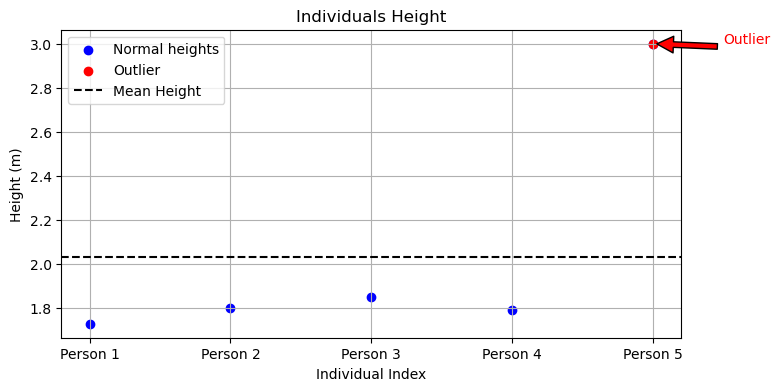

In [2]:
import numpy as np
import matplotlib.pyplot as plt

test_data = np.array([1.73, 1.8, 1.85, 1.79, 3.0])
test_data = test_data.reshape(-1, 1)
print(f"data shape: {test_data.shape}")

plt.figure(figsize=(8, 4))
plt.scatter(range(len(test_data)), test_data, color='blue', label='Normal heights')
outlier_index = np.where(test_data == 3.0)[0][0]
plt.scatter(outlier_index, test_data[outlier_index], color='red', label='Outlier')
plt.annotate('Outlier', 
             xy=(outlier_index, test_data[outlier_index]), 
             xytext=(outlier_index+0.5, test_data[outlier_index]),
             arrowprops=dict(facecolor='red', shrink=0.05),
             color='red')

plt.axhline(np.mean(test_data), color='black', linestyle='--', label='Mean Height')
plt.title("Individuals Height")
plt.xlabel("Individual Index")
indices = np.arange(len(test_data))
plt.xticks(indices, [f"Person {i + 1}" for i in indices])
plt.ylabel("Height (m)")
plt.legend()
plt.grid(True)
plt.show()

## Leave-One-Out (LOO) Estimation

The LOO method computes the mean of the dataset each time one participant is removed. This reveals how much influence each individual has on the mean, particularly sensitive in datasets with outliers.

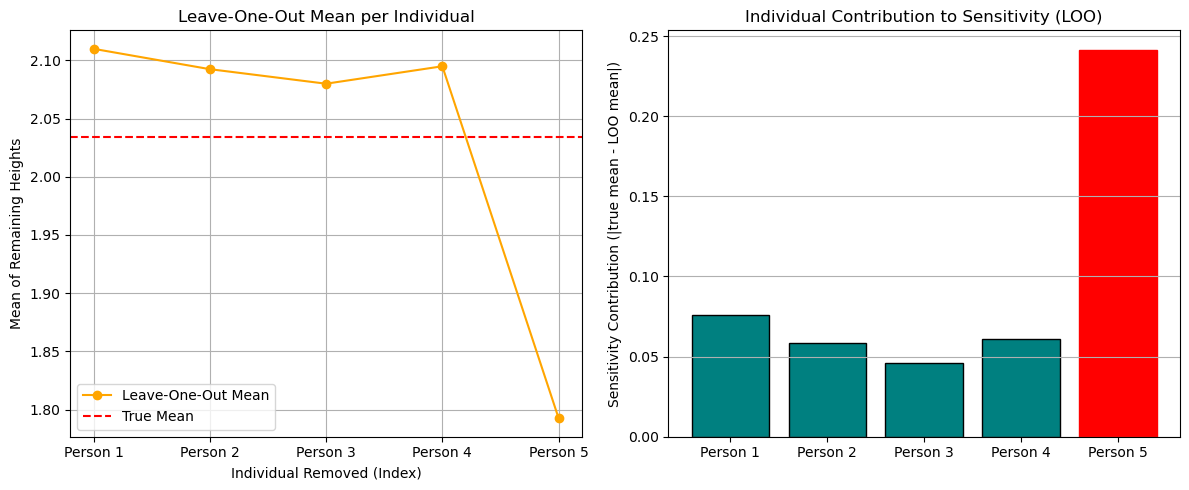

In [3]:
aprx_est = np.array([np.mean(np.delete(test_data, i)) for i in range(test_data.shape[0])]).reshape(-1, 1)

n = len(test_data)
true_mean = np.mean(test_data)
loo_means = np.array([np.mean(np.delete(test_data, i)) for i in range(n)])

sensitivity = np.abs(true_mean - loo_means)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(range(len(aprx_est)), aprx_est, marker='o', color='orange', label='Leave-One-Out Mean')
axes[0].axhline(true_mean, color='red', linestyle='--', label='True Mean')
axes[0].set_title("Leave-One-Out Mean per Individual")
axes[0].set_xlabel("Individual Removed (Index)")
axes[0].set_xticks(range(n))
axes[0].set_xticklabels([f"Person {i + 1}" for i in range(n)])
axes[0].set_ylabel("Mean of Remaining Heights")
axes[0].legend()
axes[0].grid(True)

bars = axes[1].bar(range(n), sensitivity, color='teal', edgecolor='black')
bars[-1].set_color('red')  
axes[1].set_xticks(range(n))
axes[1].set_xticklabels([f"Person {i + 1}" for i in range(n)])
axes[1].set_ylabel("Sensitivity Contribution (|true mean - LOO mean|)")
axes[1].set_title("Individual Contribution to Sensitivity (LOO)")
axes[1].grid(axis='y')

plt.tight_layout()
plt.show()


## Observation:

One individual (with height 3.0 meters) causes a significant drop in the mean when removed, clearly indicating it's an outlier or someone that differs from others in height. An attacker could identify this participant due to their disproportionate influence on the aggregate statistic.

# Data Leakage
LOO means are vulnerable in non-private settings because they provide overlapping views of the dataset. When the group size is small like here we have 5 people only, the LOO means can be inverted to reveal the original values exactly. An attacker can compute the sum of the remaining 4 values for each LOO mean and achieve the original data by solving a linear equation. 

Here we show how LOO means can be used to reconstruct the original values by solving a linear equations.
This is the height of individuals which attacker does not have access.

$$ [1.73, 1.8, 1.85, 1.79, 3.0] $$

Assuming a study has published their result in form of LOO mean

$$ [2.11, 2.093, 2.08, 2.095 , 1.79]$$ 


### DP as solution

If the data publisher add noise to the LOO means before releasing the result. For example, by adding Laplace noise proportional to the L1 sensitivity of the mean. The attacker cannot recover the true values exactly, because the values are altered with noise. 

We implement a basic DP mechanism by adding Laplace noise scaled by sensitivity, defined here as the maximum deviation between the true mean and the leave-one-out estimates.

Below we show the whole process.

Original data: [1.73 1.8  1.85 1.79 3.  ]
Reconstructed: [1.73 1.8  1.85 1.79 3.  ]
Reconstructed from noisy LOO: [1.547 1.617 1.667 1.607 2.817]


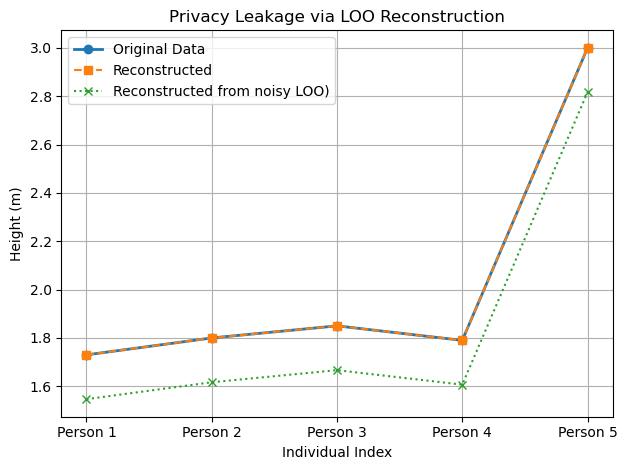

In [4]:
print("Original data:", test_data.flatten())
print("Reconstructed:", np.linalg.solve(np.ones((n, n)) - np.eye(n), 4 * loo_means))

def dp(loo_mean):
    all_noise = np.full(loo_mean.shape[1], np.nan)

    for p_loo_mean in range(loo_mean.shape[1]):
        loo_estimate = loo_mean[:, p_loo_mean]
        true_mean = np.mean(loo_estimate)
        sensitivity = np.max(np.abs(true_mean - loo_estimate)) 
        noise = np.random.laplace(loc=0.0, scale=sensitivity)
        all_noise[p_loo_mean] = noise
    
    return all_noise
noise = dp(aprx_est)
noisy_loo = aprx_est.flatten() + 1 * noise.flatten()
print("Reconstructed from noisy LOO:", np.round(np.linalg.solve(np.ones((n, n)) - np.eye(n), 4 * noisy_loo), 3))

indices = np.arange(len(test_data))

plt.plot(indices, test_data, marker='o', label='Original Data', linewidth=2)
plt.plot(indices, np.linalg.solve(np.ones((n, n)) - np.eye(n), 4 * loo_means), marker='s', label='Reconstructed', linestyle='--')
plt.plot(indices, np.linalg.solve(np.ones((n, n)) - np.eye(n), 4 * noisy_loo), marker='x', label='Reconstructed from noisy LOO)', linestyle='dotted')

plt.title("Privacy Leakage via LOO Reconstruction")
plt.xlabel("Individual Index")
plt.ylabel("Height (m)")
plt.xticks(indices, [f"Person {i + 1}" for i in indices])
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

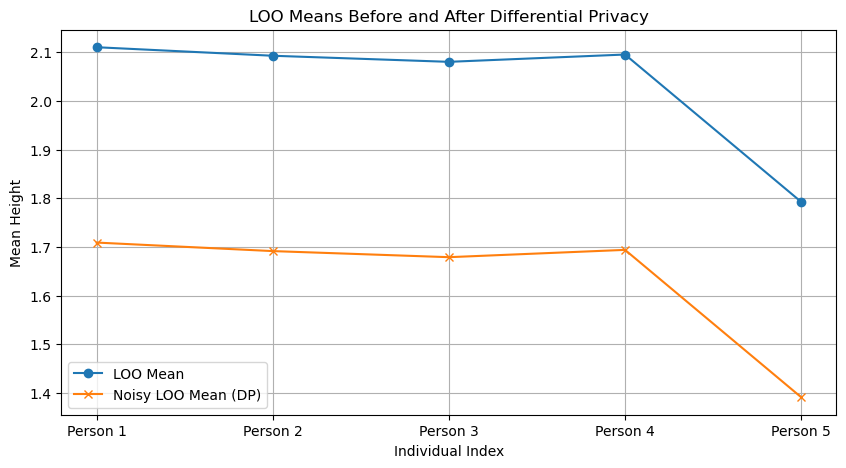

In [5]:
noise = dp(aprx_est)
noisy_mean = aprx_est.flatten() + 1 * noise.flatten()
plt.figure(figsize=(10, 5))
plt.plot(aprx_est.flatten(), label='LOO Mean', marker='o')
plt.plot(noisy_mean, label='Noisy LOO Mean (DP)', marker='x')
plt.title("LOO Means Before and After Differential Privacy")
plt.xlabel("Individual Index")
indices = np.arange(len(test_data))
plt.xticks(indices, [f"Person {i + 1}" for i in indices])
plt.ylabel("Mean Height")
plt.legend()
plt.grid(True)
plt.show()


In [6]:
noise = dp(aprx_est)
print(f"Noise: {noise}")
noisy_mean = aprx_est + 1 * noise 
print(f"LOO mean: {aprx_est.flatten()}")
print(f"Noisy mean: {noisy_mean.flatten()}")
print(f"Found subject index:", np.argmin(np.abs(noisy_mean.flatten())))

Noise: [0.31209793]
LOO mean: [2.11   2.0925 2.08   2.095  1.7925]
Noisy mean: [2.42209793 2.40459793 2.39209793 2.40709793 2.10459793]
Found subject index: 4


## Simulation
Here we simulate a potential privacy attack scenario where an adversary attempts to reconstruct the original individual data values from noisy LOO means.

To protect privacy, Laplace noise is added to the LOO means using the DP mechanism. However, even after adding noise, it's important to evaluate how well the attacker could still reconstruct the original values. 

The DP mechanism is randomized, each execution adds different noise. So, we run a Monte Carlo (MC) simulation 1000 times to:

- Simulate many possible outcomes of the noisy LOO release.
- Perform reconstruction attempts based on each noisy release.
- Visualize the distribution of attacker guesses for each individual’s value.

This allows us to:

- Understand the variability in the reconstructions.
- Check whether the true values are consistently hidden within a wide distribution.
- Provide empirical evidence that the data remains private on average, even if some reconstructions appear close by chance.

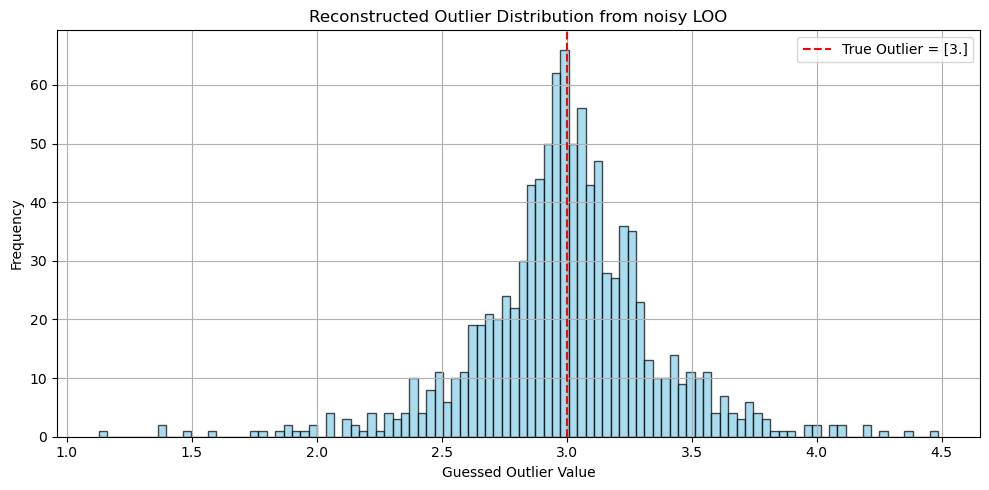

In [7]:
outlier_index = np.argmin(np.abs(noisy_mean.flatten()))
MC = 1000
rec = np.zeros((MC, n))  

for i in range(MC):
    noise = dp(aprx_est)
    noisy_loo = aprx_est.flatten() + 1 * noise.flatten()
    rec[i] = np.linalg.solve(np.ones((n, n)) - np.eye(n), 4 * noisy_loo)

plt.figure(figsize=(10, 5))
plt.hist(rec[:, outlier_index], bins=100, color='skyblue', alpha=0.7, edgecolor='black')
plt.axvline(test_data[outlier_index], color='red', linestyle='--', label=f"True Outlier = {test_data[outlier_index]}")
plt.title("Reconstructed Outlier Distribution from noisy LOO")
plt.xlabel("Guessed Outlier Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


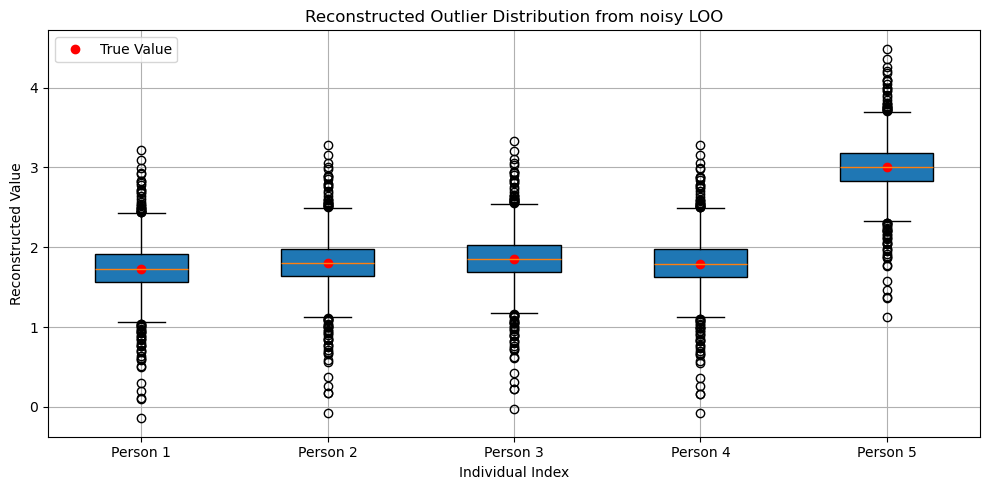

In [8]:
plt.figure(figsize=(10, 5))
plt.boxplot(rec, labels=[f"Person {i+1}" for i in range(n)], patch_artist=True)
plt.plot(range(1, n+1), test_data, 'ro', label="True Value") 
plt.title("Reconstructed Outlier Distribution from noisy LOO")
plt.xlabel("Individual Index")
plt.ylabel("Reconstructed Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Interpretation

This plot visually confirms that with proper noise added, for example Laplace via L1 sensitivity, no individual including outlier can be reliably reconstructed, even over 1000 Monte Carlo attempts.

This demonstrates that differential privacy adds enough uncertainty to block attackers from confidently inferring sensitive information, even when they know the structure of the LOO means.